In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    r2_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
)
import warnings
warnings.filterwarnings("ignore")


In [14]:
# Load dataset
df = pd.read_csv("cleaned_air_quality_data.csv")

# Keep relevant columns and drop missing/invalid values
pollutants = ['so2', 'no2', 'rspm', 'spm']
cat_cols = ['type', 'state', 'city']
df = df[pollutants + ['year', 'month'] + cat_cols].dropna()
df = df[(df[pollutants] > 0).all(axis=1)]

# Add feature interactions
df['so2_x_no2'] = df['so2'] * df['no2']
df['rspm_x_spm'] = df['rspm'] * df['spm']

# One-hot encode categorical variables
df_encoded = pd.get_dummies(df, columns=cat_cols, drop_first=True)


In [15]:
# Store evaluation metrics and models
results = {}
models = {}
predictions = {}

for target in pollutants:
    features = [col for col in df_encoded.columns if col != target]
    X = df_encoded[features]
    y = df_encoded[target]
    y_log = np.log1p(y)

    X_train, X_test, y_train, y_test = train_test_split(
        X, y_log, test_size=0.3, random_state=42
    )

    model = XGBRegressor(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=6,
        objective='reg:squarederror',
        early_stopping_rounds=15,
        eval_metric='rmse',
        verbosity=0
    )

    model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)

    y_pred_log = model.predict(X_test)
    y_pred = np.expm1(y_pred_log)
    y_test_actual = np.expm1(y_test)

    # Store results
    r2 = r2_score(y_test_actual, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test_actual, y_pred))
    mae = mean_absolute_error(y_test_actual, y_pred)
    mape = mean_absolute_percentage_error(y_test_actual, y_pred)

    results[target.upper()] = {
        'R² Score': round(r2, 4),
        'RMSE': round(rmse, 4),
        'MAE': round(mae, 4),
        'MAPE': f"{round(mape * 100, 2)}%"
    }

    models[target.upper()] = model
    predictions[target.upper()] = (y_test_actual, y_pred)


In [16]:
print("Final Regression Results (Enhanced Accuracy with Interactions)\n")
for pollutant, metrics in results.items():
    print(f"{pollutant}")
    for k, v in metrics.items():
        print(f"  {k}: {v}")
    print()


Final Regression Results (Enhanced Accuracy with Interactions)

SO2
  R² Score: 0.968
  RMSE: 0.7456
  MAE: 0.1267
  MAPE: 1.31%

NO2
  R² Score: 0.988
  RMSE: 1.3495
  MAE: 0.359
  MAPE: 1.28%

RSPM
  R² Score: 0.9792
  RMSE: 6.8947
  MAE: 1.3346
  MAPE: 1.4%

SPM
  R² Score: 0.9857
  RMSE: 12.0637
  MAE: 2.806
  MAPE: 1.28%



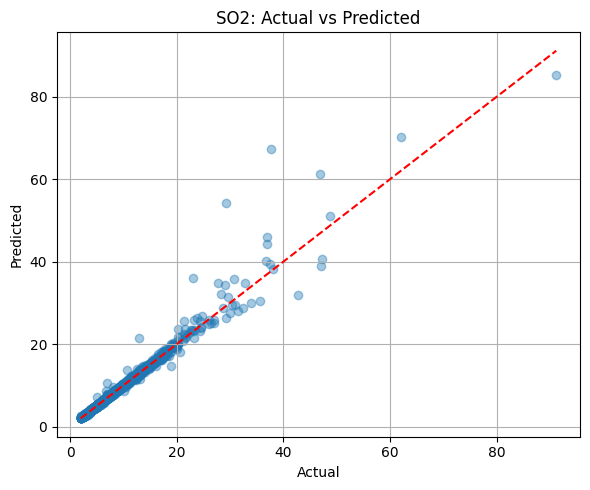

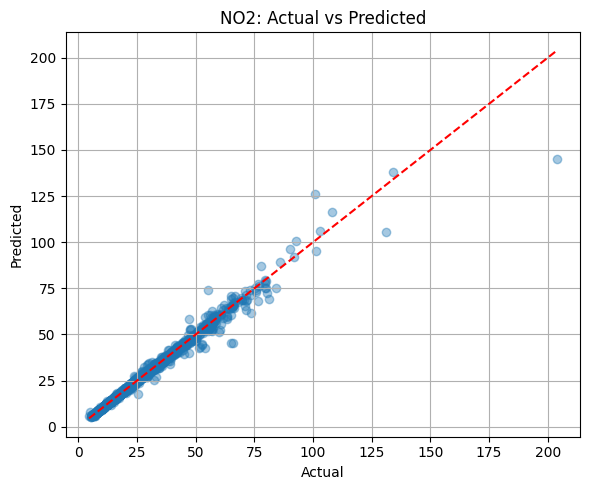

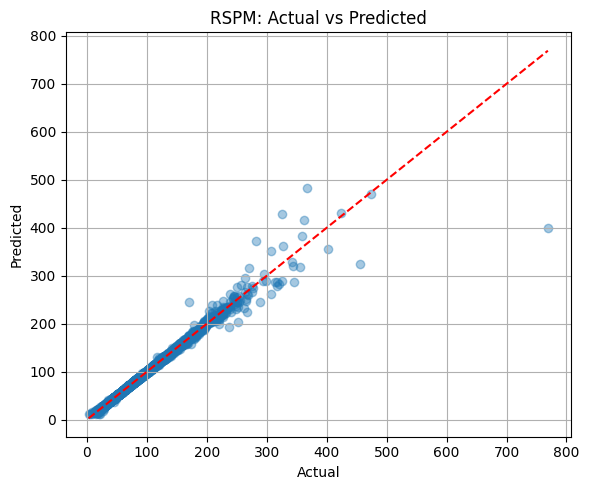

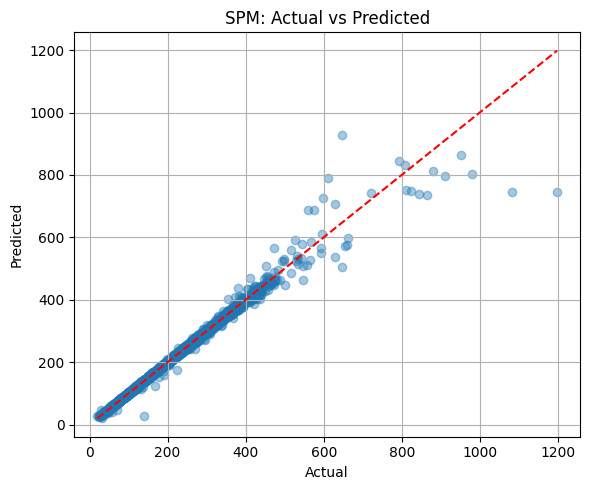

In [27]:
for pollutant, (y_true, y_pred) in predictions.items():
    plt.figure(figsize=(6, 5))
    plt.scatter(y_true, y_pred, alpha=0.4)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.title(f"{pollutant}: Actual vs Predicted")
    plt.grid(True)
    plt.tight_layout()
    plt.show()
